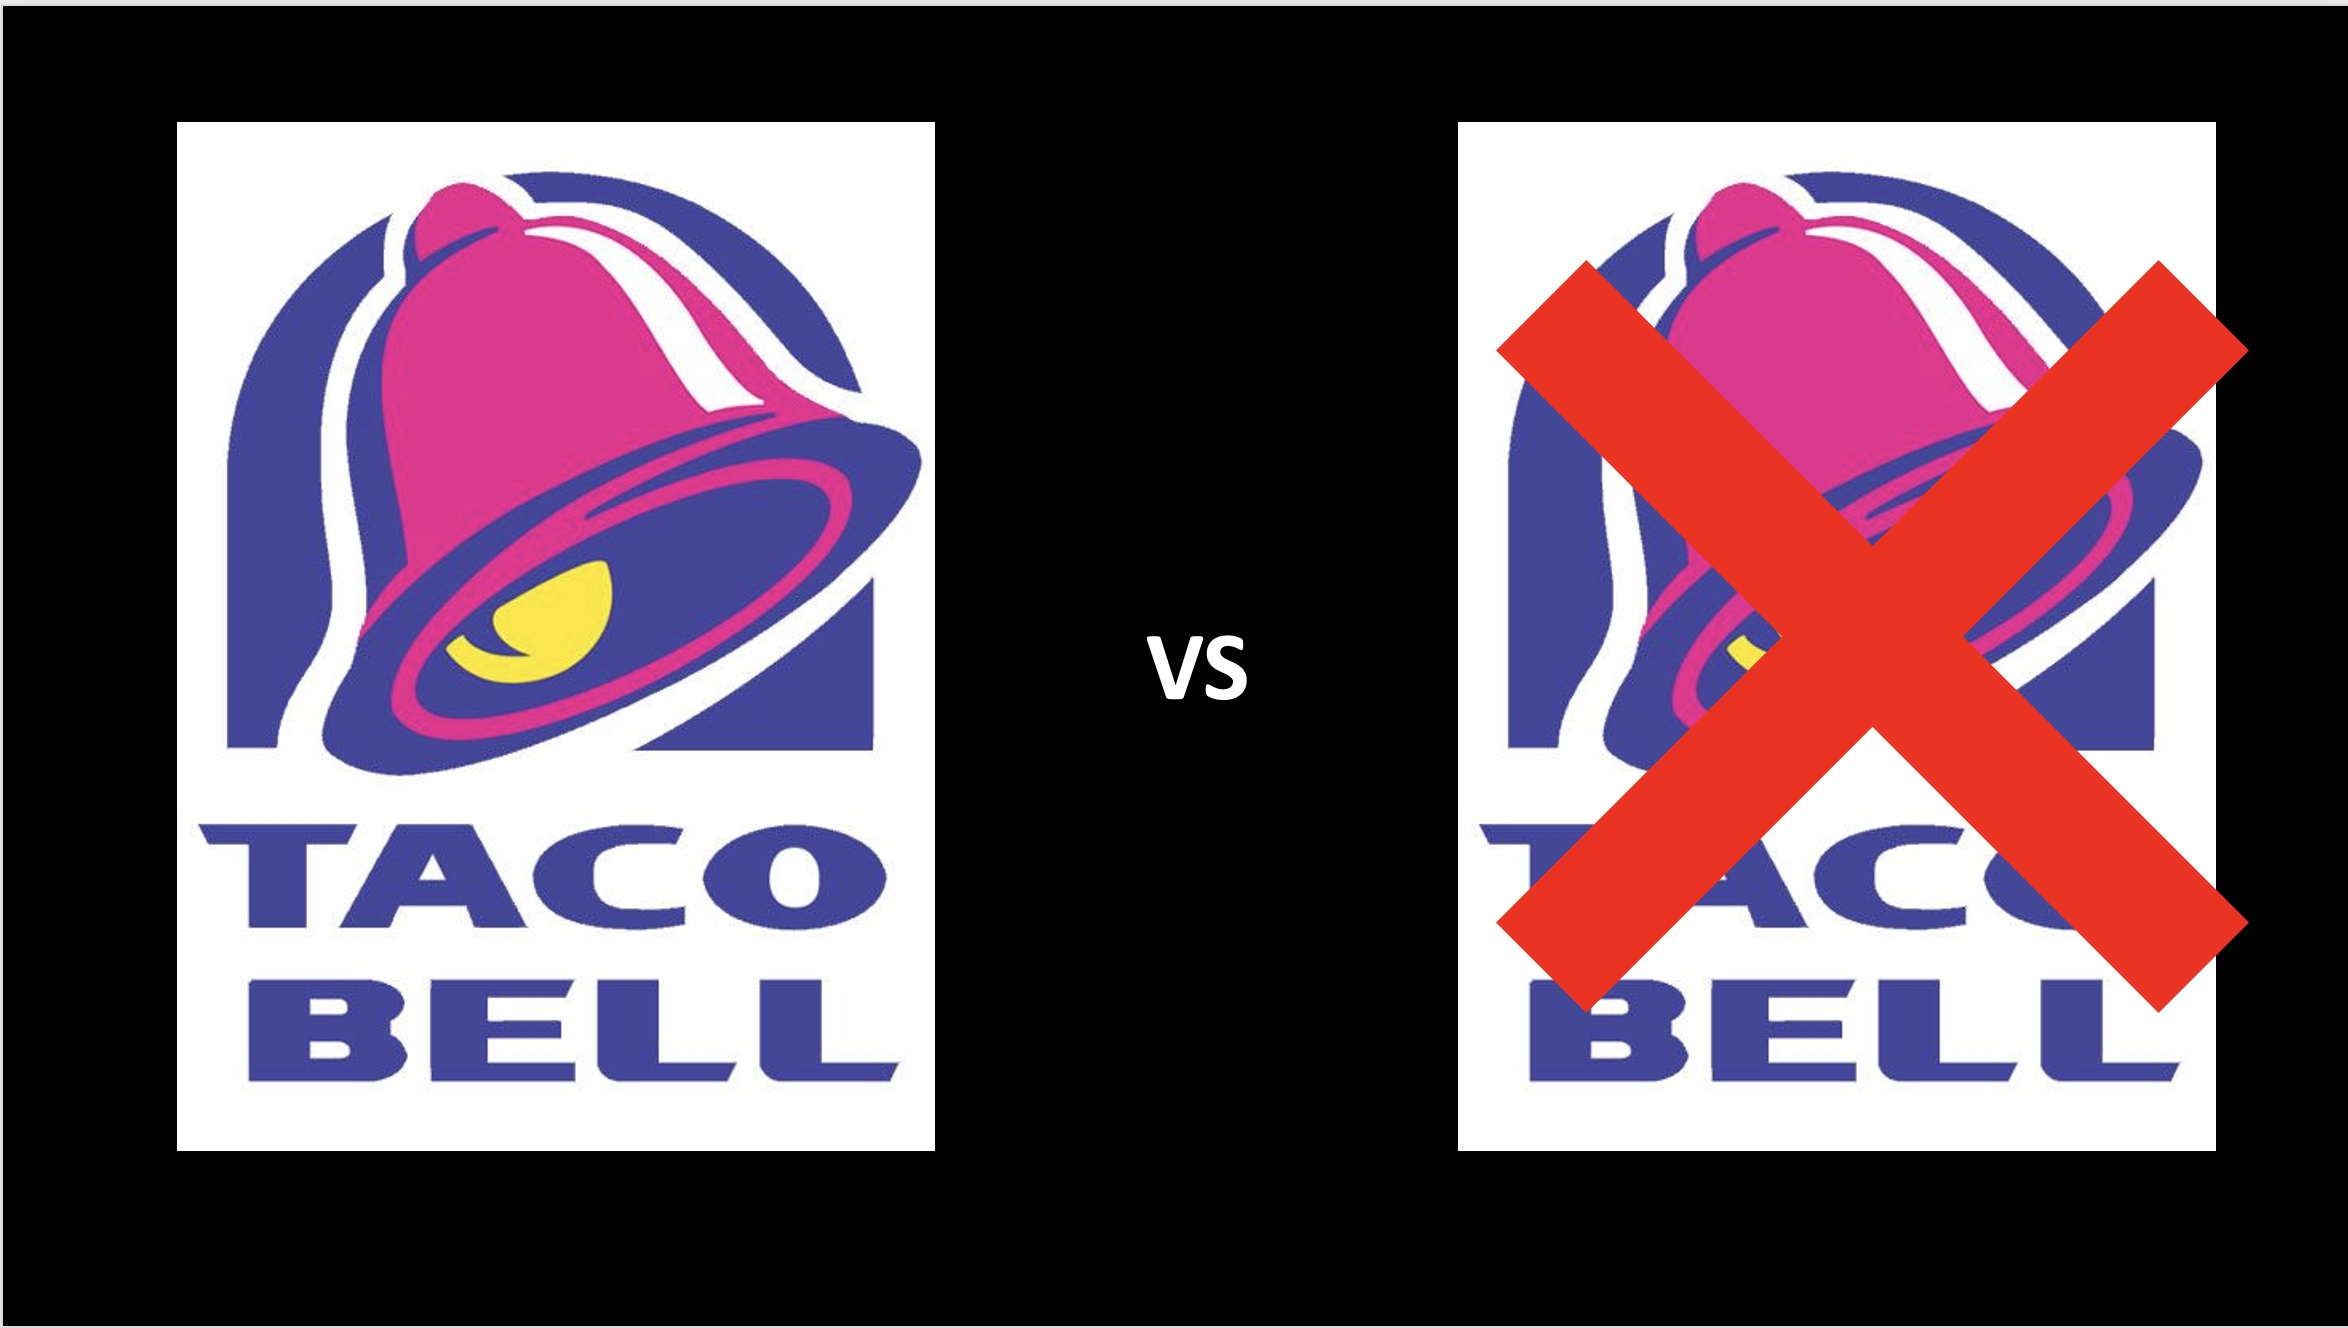

This tutorial notebook is designed to show how Modin can speed up Hugging Face workloads. If you haven't already read it, check out the blo post here:https://ponder.io/faster-hugging-face-with-modin/

# Step 0: Import the requirements

In [ ]:
# pandas and modin
import pandas as old_pd
import modin.pandas as pd

# Hugging Face requirements
from transformers import pipeline, DistilBertTokenizer

#misc
import time

# Step 1: Read in the data

###  Reading from S3 With Pandas

In [29]:
%%time
business=old_pd.read_csv("s3://my-ponder-demos/business.csv")
reviews=old_pd.read_csv("s3://my-ponder-demos/review.csv")

CPU times: user 1min 9s, sys: 9.26 s, total: 1min 18s
Wall time: 3min 52s


### Reading from S3 With Modin

In [4]:
%%time
business=pd.read_csv("s3://my-ponder-demos/yelp_business.csv")
reviews=pd.read_csv("s3://my-ponder-demos/yelp_review.csv")

CPU times: user 22.3 s, sys: 7.4 s, total: 29.7 s
Wall time: 1min 25s


<h1 align="center"><center>               🔥🔥🔥  3X Speedup on Reading from S3! 🔥🔥🔥 </h1>

# Step 2: Explore the data

In [13]:
# What's in a business record
business.head(3)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...


In [14]:
# What's in a review?
reviews.head(3)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0


### ~5M Record Sample - 3.8GB

In [14]:
print("business records: {:,}".format(business.shape[0]))
print("reviews records: {:,}".format(reviews.shape[0]))

business records: 174,567
reviews records: 5,261,668


<h2 align="center">The User Experience is THE SAME!</h2>

''

# <h1 align="center">🌮🌮🌮🌮 TACO BELL vs. NOT TACO BELL 🌮🌮🌮🌮</h1>

# Step 3: Pre-Processing Data for NLP

### Pre-processing with Pandas

In [7]:
%%time
reviews['text2'] = reviews.text.str.lower()
        
# get the length of the df
reviews['length'] = reviews['text2'].apply(lambda x: len(x))
reviews = reviews.sort_values(by=['length'], ascending=False)

# drop rows that have a length of more than 512 characters, model can't handle them
reviews.drop(reviews[reviews['length'] >= 512].index, inplace = True)

# drop the entire length column - we don't need it anymore
reviews.drop('length', axis=1, inplace=True)

# Add "Is Mexican Food Flag"
reviews =  reviews.merge(business[["business_id","name", "is_mexican_food"]],how="left",on="business_id")

#Subset to mexican + useful
mexican_food_reviews = reviews[reviews.is_mexican_food==True]
useful_reviews = mexican_food_reviews[mexican_food_reviews.useful > 1]
del reviews

CPU times: user 28.1 s, sys: 2.99 s, total: 31.1 s
Wall time: 30.9 s


### Pre-processing with Modin

In [25]:
%%time
reviews['text2'] = reviews.text.str.lower()
        
# get the length of the df
reviews['length'] = reviews['text2'].apply(lambda x: len(x))
reviews = reviews.sort_values(by=['length'], ascending=False)

# drop rows that have a length of more than 512 characters, model can't handle them
reviews.drop(reviews[reviews['length'] >= 512].index, inplace = True)

# drop the entire length column - we don't need it anymore
reviews.drop('length', axis=1, inplace=True)

# Add "Is Mexican Food Flag"
reviews =  reviews.merge(business[["business_id","name", "is_mexican_food"]],how="left",on="business_id")

#Subset to mexican + useful
mexican_food_reviews = reviews[reviews.is_mexican_food==True]
useful_reviews = mexican_food_reviews[mexican_food_reviews.useful > 1]
del reviews

CPU times: user 2.06 s, sys: 418 ms, total: 2.48 s
Wall time: 18.9 s


<h1><center> 🔥 Almost 2X Faster Pre Processing 🔥 </center></h1>

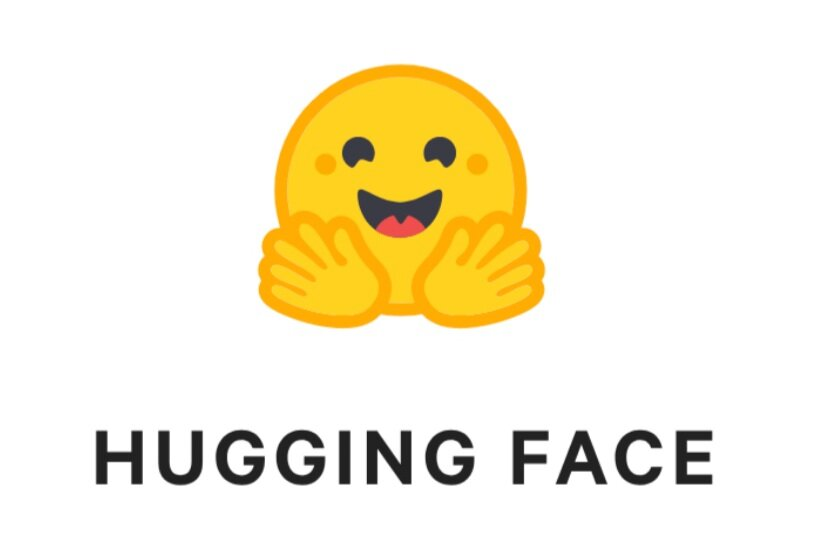

# Step 4: Defining the Sentiment Analysis pipeline

In [8]:
d_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

classifier = pipeline("sentiment-analysis", model="j-hartmann/emotion-english-distilroberta-base",max_length=512,truncation=True, tokenizer= d_tokenizer)

def sentiment_classifier(text):

    classifier_results = classifier(text)[0]
    return classifier_results['label'],classifier_results['score']

# Step 5: Executing the Hugging Face pipeline

### Sentiment Analysis with Modin

In [ ]:
%%time
mexican_food_reviews['sentiment'],mexican_food_reviews['score'] = zip(*mexican_food_reviews.apply(lambda x: sentiment_classifier(x['text2']),axis=1))

<h1><center>😩😩😩 System crashes after 5 HOURS!! 😩😩😩 </h1></center>

### Sentiment Analysis with Modin

In [36]:
%%time
mexican_food_reviews['sentiment'],mexican_food_reviews['score'] = zip(*mexican_food_reviews.apply(lambda x: sentiment_classifier(x['text2']),axis=1))

CPU times: user 11.1 s, sys: 2.42 s, total: 13.5 s
Wall time: 23min 34s


<h1><center> +12X Faster AND More Reliable Hugging Face Inference 😎 </h1></center>